In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from idlmam import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/drive/MyDrive/Colab Notebooks/idlmam.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from google.colab import files
# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gohgogoh","key":"7dcdea4e9d14f256a828fd2028fe49d8"}'}

In [3]:
import os
# Create .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

# Set permissions
os.chmod('/root/.kaggle/kaggle.json', 600)


In [4]:
# Download dataset
!kaggle datasets download -d elvinagammed/chatbots-intent-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/elvinagammed/chatbots-intent-recognition-dataset
License(s): copyright-authors
chatbots-intent-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip chatbots-intent-recognition-dataset.zip

Archive:  chatbots-intent-recognition-dataset.zip
replace Intent.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [11]:
import kagglehub
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import glob
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from PIL import Image
import re
import json
from sklearn.model_selection import train_test_split
import pickle

In [7]:
import os
os.listdir("/content/")

['.config',
 'tokenizer.pkl',
 'trained_rnn_model.pth',
 '.ipynb_checkpoints',
 'Intent.json',
 'drive',
 'label_encoder.pkl',
 'chatbots-intent-recognition-dataset.zip',
 'sample_data']

In [8]:
# Load the dataset
with open("Intent.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Inspect structure
print(json.dumps(data, indent=2))

# Extract text patterns and intents
patterns, intents = [], []

for intent_data in data["intents"]:
    intent_name = intent_data["intent"]  # Correct key for intent name
    for pattern in intent_data.get("text", []):  # Correct key for user phrases
        patterns.append(pattern)
        intents.append(intent_name)

# Convert to DataFrame
df = pd.DataFrame({"patterns": patterns, "intents": intents})

# Preview the data
print(df.head())

{
  "intents": [
    {
      "intent": "Greeting",
      "text": [
        "Hi",
        "Hi there",
        "Hola",
        "Hello",
        "Hello there",
        "Hya",
        "Hya there"
      ],
      "responses": [
        "Hi human, please tell me your GeniSys user",
        "Hello human, please tell me your GeniSys user",
        "Hola human, please tell me your GeniSys user"
      ],
      "extension": {
        "function": "",
        "entities": false,
        "responses": []
      },
      "context": {
        "in": "",
        "out": "GreetingUserRequest",
        "clear": false
      },
      "entityType": "NA",
      "entities": []
    },
    {
      "intent": "GreetingResponse",
      "text": [
        "My user is Adam",
        "This is Adam",
        "I am Adam",
        "It is Adam",
        "My user is Bella",
        "This is Bella",
        "I am Bella",
        "It is Bella"
      ],
      "responses": [
        "Great! Hi <HUMAN>! How can I help?",
        "Goo

In [13]:
# Tokenize text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df["patterns"])
sequences = tokenizer.texts_to_sequences(df["patterns"])

# Determine max sequence length
max_length = max(len(seq) for seq in sequences)

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding="post")

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(intents)

# Save the tokenizer and label encoder for later use
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# Prepare training data as tensors
X_train = torch.tensor(padded_sequences, dtype=torch.long)
y_train = torch.tensor(encoded_labels, dtype=torch.long)

# Convert to TensorFlow dataset
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print dataset information
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(X_train)}")


Total samples: 143
Training samples: 143


In [84]:
class LastTimeStep(nn.Module):
    def __init__(self, rnn_layers, bidirectional):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        self.bidirectional = bidirectional

    def forward(self, rnn_output):
        # rnn_output is a tuple: (output, hidden_state)
        output, hidden_state = rnn_output
        return output[:, -1, :]  # Extract the last timestep from the output

In [85]:
vocab_size = len(tokenizer.word_index) + 1
classes = len(label_encoder.classes_)

# Hyperparameters
learning_rate = 0.001
num_epochs = 30
num_layers = 4
hidden_nodes = 256
embedding_dim = 30
bidirectional = True

# RNN Model Definition
rnn_model = nn.Sequential(
    nn.Embedding(vocab_size, embedding_dim),  # (B, T) -> (B, T, D)
    nn.RNN(embedding_dim, hidden_nodes, num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=0.2),
    LastTimeStep(rnn_layers=num_layers, bidirectional=bidirectional),  # Reduces output to (B, D)
    nn.Linear(hidden_nodes * 2 if bidirectional else hidden_nodes, classes)  # Adjust output based on directionality
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_model.to(device)

loss_func = nn.CrossEntropyLoss()

y_true = []
y_pred = []

# Train the RNN
trained_rnn = train_simple_network(
    rnn_model,
    loss_func,
    train_loader,
    test_loader=test_loader,
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    epochs=num_epochs,
    lr=learning_rate
)

# Save the trained model
torch.save(rnn_model.state_dict(), 'trained_rnn_model.pth')

# Get predictions for the test set
y_pred = []
y_true = []

# Assuming `test_loader` is your test data loader
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = rnn_model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Get target names from label encoder
target_names = label_encoder.classes_


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

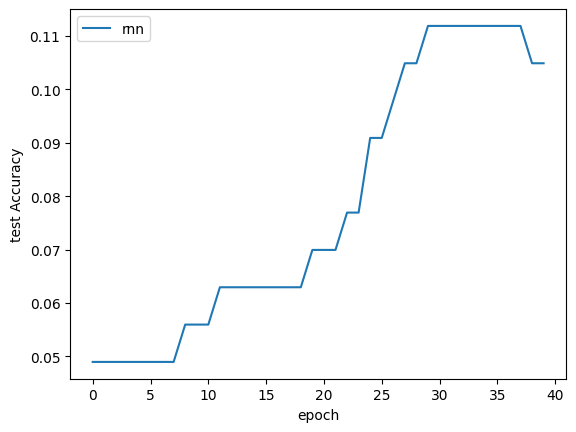

In [82]:
sns.lineplot(x='epoch', y='test Accuracy', data=trained_rnn, \
             label='rnn')

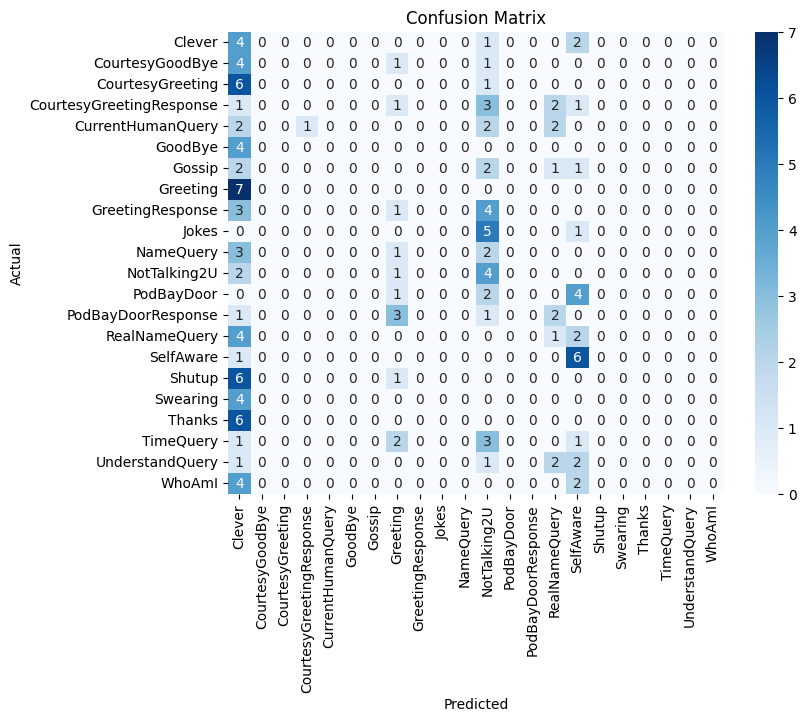

In [83]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
